# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

# Define

In [282]:
def array_sign(array):
    # return +1, 0, -1 respect to positive, zero, negtive
    return 1.*(array>0) - 1.*(array<0)

def column_operate(matrix, thresh_hold = 0.001):
    rm = np.array(matrix) # reduced matrix
    fm = np.array(matrix) # filtered matrix
    ms = matrix.shape # matrix size
    mk = np.ones(matrix.shape) # mask
    pv = -1*np.ones((ms[1])) # pivots
    for t in range(ms[1]):
        fm = rm*mk # filtered matrix
        if np.abs(fm).max() < thresh_hold:
            break
        
        pr, pc = np.unravel_index(np.abs(fm).argmax(), ms) # pivot row, pivot column
        rm[:,pc] /= rm[pr][pc]
        multi = np.array(rm[pr])
        multi[pc] = 0.
        rm -= np.dot(rm[:,pc].reshape((ms[0], 1)), multi.reshape((1, ms[1])))
        mk[pr] = 0.
        mk[:,pc] = 0.
        pv[pc] = pr
    
    rm = rm[:, pv != -1]
    pv = pv[pv != -1].astype(np.int)
    
    return rm, pv

class VariableArray():
    def __init__(self, size, cs_initial=0.1):
        self.v = np.random.normal(0., 1., size) # array values
        self.td = np.zeros(self.v.shape) # total derivative, used to descent
        self.ltd = None # last total derivative
        self.m = np.zeros(self.v.shape) # moving array
        self.cs = cs_initial*np.ones(self.v.shape) # component-wise step
        self.work = np.ones(self.v.shape) # working components, defult to be fully connected
    
    def assign_values(self, values, cs_initial=0.1):
        self.v = np.array(values)
        self.td = np.zeros(self.v.shape)
        self.ltd = None
        self.m = np.zeros(self.v.shape)
        self.cs = cs_initial*np.ones(self.v.shape)
        self.work = np.ones(self.v.shape)
    
    def derivative_assign(self, values):
        if values.shape != self.td.shape:
            raise ValueError("values shape error")
        
        self.ltd = np.array(self.td)
        self.td = values
    
    def max_cs(self):
        return self.cs.max()
    
    def descent(self, step = 1., descent_method = "normal", regularizer = ("None",),step_max=1., step_min=0.000001):
        if regularizer[0] == "r_square":
            self.td += regularizer[1] * self.v
        
        if regularizer[0] == "rs_extend":
            self.td += regularizer[1] * ((self.v>regularizer[2])*(self.v-regularizer[2]) + (self.v < -regularizer[2])*(self.v+regularizer[2]))
        
        if descent_method == "normal":
            self.m = np.array(self.td)
            self.v -= step * self.m * self.work
        elif descent_method == "Rprop":
            self.m = array_sign(self.td)
            self.cs *= 1.2*(self.td*self.ltd>0) + 1.*(self.td*self.ltd==0) + 0.5*(self.td*self.ltd<0)
            self.cs = self.cs * (self.cs < step_max) * (self.cs > step_min)+ step_max*(self.cs >= step_max) + step_min*(self.cs <= step_min)
            self.v -= self.cs * self.m * self.work
        elif descent_method == "Dogiko Rprop":
            self.m = array_sign(self.td)
            step_change = 1.2*(self.td*self.ltd>0.) + 1.*(self.td*self.ltd==0.) + 1.*(self.td==self.ltd)
            step_change[step_change == 0.] = self.td[step_change == 0.]/(self.ltd-self.td)[step_change == 0.]
            step_change[step_change < 0.1] = 0.1
            self.cs *= step_change
            
            self.cs = self.cs * (self.cs < step_max) * (self.cs > step_min)+ step_max*(self.cs >= step_max) + step_min*(self.cs <= step_min)
            self.v -= self.cs * self.m * self.work

# Activation functions defined start

class Identity():
    def trans(self, x):
        return x
    
    def diff(self, x):
        return np.ones(x.shape, dtype = np.float64)

class Sigmoid():
    def trans(self, x):
        return expit(x)
    
    def diff(self, x):
        return expit(x)*expit(-x)

class Hypertan():
    def trans(self, x):
        return np.tanh(x)
    
    def diff(self, x):
        return 1. / np.square(np.cosh(x))

class Relu():
    def trans(self, x):
        return x*(x>0)
    
    def diff(self, x):
        return 1.*(x>0)

class LeakyRelu():
    def __init__(self, alpha = 0.1):
        self.alpha = alpha
    
    def trans(self, x):
        return x*(x>0) + self.alpha*x*(x<0)
    
    def diff(self, x):
        return 1.*(x>0) + self.alpha*(x<0)

class SoftPlus():
    def trans(self, x):
        return np.log(1. + np.exp(x))
    
    def diff(self, x):
        return expit(x)

class Selu():
    def __init__(self):
        self.ahpha = 1.05071
        self.beta = 1.67326
    
    def trans(self, x):
        return self.ahpha*(x*(x>0) + self.beta*(np.exp(x) - 1)*(x<0))
    
    def diff(self, x):
        return self.ahpha*((x>0) + self.beta*np.exp(x)*(x<0))

# Activation functions defined end

class Layer():
    def __init__(self, neuron_n, activation_function):
        self.nn = neuron_n
        self.af = activation_function
        self.w = VariableArray((self.nn, 0)) # linear weights working before active function
        self.b = VariableArray((self.nn)) # bias working before active function
        self.x = np.zeros((0, self.nn))
        self.y = np.zeros((0, self.nn))
    
    def forward(self, _input):
        temp_dn = _input.shape[1] # _input datum n
        self.x = np.dot(self.w.v, _input) + self.b.v.repeat(temp_dn).reshape((self.nn, temp_dn))
        self.y = self.af.trans(self.x)
    
    def backward(self, _input, source):
        derivative = self.af.diff(self.x)*_input
        self.w.derivative_assign(np.dot(derivative, source.T))
        self.b.derivative_assign(np.sum(derivative, axis=1))
        derivative = np.dot(derivative.T, self.w.v)
        return derivative.T
    
    def descent(self, step, descent_method, regularizer):
        self.w.descent(step, descent_method, regularizer)
        self.b.descent(step, descent_method, regularizer)

class DogikoLearn():
    def __init__(self, loss_function = "r2"):
        self.lf = loss_function # loss function type
        self.ly = [] # layers list
        self.rg = ("None",) # Regularizetion method
        self.csi = 0.1 # initial component-wise step when claim new weights and bias
    
    def r_square_regularizer(self, alpha):
        # Assign regularization method as radius square
        # i.e Error += alpha*0.5*sum(weight**2) when descent
        if alpha <= 0:
            raise ValueError("Input should be positive")
        
        self.rg = ("r_square", alpha)
    
    def rs_extend_regularizer(self, alpha, beta):
        # Assign regularization method as radius square
        # i.e Error += alpha*0.5sum(weight**2) when descent
        if (alpha <= 0) or (alpha <= 0):
            raise ValueError("All input should be positive")
        
        self.rg = ("rs_extend", alpha, beta)
    
    def set_training_data(self, training_input, training_labels):
        self.tx = np.array(training_input) # training data input
        self.ty = np.array(training_labels) # training data lables(answers)
        if self.tx.shape[0] != self.ty.shape[0]:
            temp_min = min(self.tx.shape[0], self.ty.shape[0])
            self.tx = self.tx[:temp_min]
            self.ty = self.ty[:temp_min]
            print("training data #input != #output, took the minimun size automatically")
        
        self.xs = self.tx.shape[1] # size of each datum input
        self.ys = self.ty.shape[1] # size of each datum output
    
    def set_validating_data(self, validating_input, validating_labels):
        self.vx = np.array(validating_input) # validating data input
        self.vy = np.array(validating_labels) # validating data lables(answers)
        if self.vx.shape[1] != self.xs:
            raise ValueError("validating data input size should be equal to training data")
        
        if self.vy.shape[1] != self.ys:
            raise ValueError("validating data lables size should be equal to training data")
    
    def add_layer(self, new_layer):
        self.ly.append(new_layer)
    
    def build(self):
        self.ln = len(self.ly) # amount of layers
        self.ly[0].w.assign_values(np.random.normal(0., 1., (self.ly[0].nn, self.xs)), self.csi)
        self.ly[0].b.assign_values(np.random.normal(0., 1., (self.ly[0].nn)), self.csi)
        for l in range(1,self.ln):
            self.ly[l].w.assign_values(np.random.normal(0., 1., (self.ly[l].nn, self.ly[l-1].nn)), self.csi)
            self.ly[l].b.assign_values(np.random.normal(0., 1., (self.ly[l].nn)), self.csi)
        
        if self.ly[-1].nn != self.ys: # cheak output size
            raise ValueError("output layer must has the same size with datum lables(answer)")
    
    def prediction(self, data_input):
        self.px = np.array(data_input) # prediction data input of last time predic
        if self.px.shape[1] != self.xs:
            raise ValueError("datum size error")
        
        self.ly[0].forward(self.px.T)
        for l in range(1,self.ln):
            self.ly[l].forward(self.ly[l-1].y)
        
        self.py = self.ly[l].y.T # prediction result of last time predict
    
    def descent(self, step = 1., descent_method = "normal"):
        for l in range(self.ln):
            self.ly[l].descent(step, descent_method, self.rg)
        
        if descent_method in ["Rprop", "Dogiko Rprop"]:
            self.max_cs = 0.
            for l in range(self.ln):
                self.max_cs = max(self.max_cs, self.ly[l].w.max_cs(), self.ly[l].b.max_cs())
    
    def batch_fit(self, batch_input, batch_labels, step = 1., descent_method = "normal"):
        self.prediction(batch_input)
        if self.lf == "r2":
            temp_derivative = 2*(self.py - batch_labels).T/(batch_labels.shape[0]*batch_labels.var(axis=0).sum())
        
        for l in range(self.ln-1, 0, -1):
            temp_derivative = self.ly[l].backward(temp_derivative, self.ly[l-1].y)
        
        self.ly[0].backward(temp_derivative, batch_input.T)
        self.descent(step, descent_method)
    
    def validate(self):
        self.prediction(self.vx)
        if self.lf == "r2":
            return np.square(self.py - self.vy).mean()/self.vy.var(axis=0).mean()


# Example 1

Fit $y = \sin{x}$

In [300]:
X = (np.arange(81)/20) - 2
X = X.reshape((81,1))
Y = np.sin(2*X)

0.00167528055933


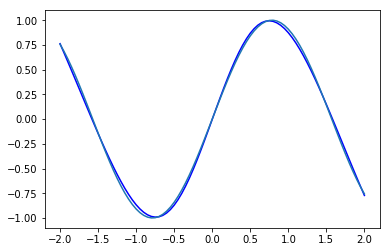

In [23]:
NN = DogikoLearn()
NN.r_square_regularizer(0.0001)
NN.set_training_data(X, Y)
NN.set_validating_data(X, Y)
NN.add_layer(Layer(50,Sigmoid()))
NN.add_layer(Layer(1,Identity()))
NN.build()

counter = 0
for i in range(10000):
    NN.batch_fit(X,Y,step=0.02, descent_method="Dogiko Rprop")
    if NN.max_cs < 0.001:
        break
    else:
        counter =0

print(NN.validate())

plt.plot(X.reshape((81)), NN.py.reshape((81)), "b", X.reshape((81)), Y.reshape((81)))
plt.show()

# Example 2

Net-shape classification

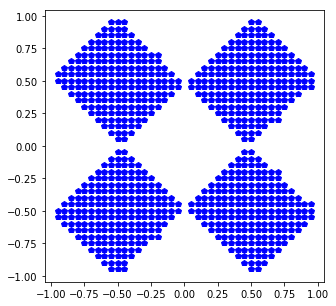

In [9]:
X = np.array([np.arange(41).repeat(41), np.arange(41*41) % 41]).astype(np.float64)
X -= 20.
X /= 20.
Y = (((X[0] + X[1] - 0.5) % 2.) > 1.) ^ (((X[0] - X[1] - 0.5) % 2.) > 1.)
Y = Y.reshape((Y.shape + (1,))).astype(np.float64)
X = X.T
plt.figure(figsize=(5,5))
plt.plot(X.T[0][Y.T[0] == 1], X.T[1][Y.T[0] == 1], "bp")
plt.show()

In [77]:
NN = DogikoLearn()
NN.rs_extend_regularizer(0.1,1.)
NN.set_training_data(X, Y)
NN.set_validating_data(X, Y)
NN.add_layer(Layer(50,Sigmoid()))
NN.add_layer(Layer(30,Sigmoid()))
NN.add_layer(Layer(20,Sigmoid()))
NN.add_layer(Layer(1,Sigmoid()))
NN.build()

for i in range(10000):
    NN.batch_fit(X,Y,step=0.1, descent_method="Dogiko Rprop")
    if NN.max_cs < 0.005:
        print(i)
        break
    
    if (i+1) % 100 == 0:
        print(NN.max_cs)

print(NN.validate())

for l in range(len(NN.ly)):
    print(max(np.abs(NN.ly[l].w.v).max(), np.abs(NN.ly[l].b.v).max()))

0.231129767502
0.290740797444
0.119257883312
0.296751776202
0.231129767502
0.0391302183008
0.0676170172238
0.0247293146835
0.0373287478235
0.0283089967321
1000
0.295642730429
1.05690086614
1.02269877481
1.02247784318
1.13073751743


In [325]:
X = np.zeros((303))
for t in range(3):
    X[101*t:101*(t+1)] = (np.arange(101)-250+(200*t))*0.01
Y = 1.*(np.arange(303) >= 101) * (np.arange(303) < 202)
X = X.reshape(X.shape + (1,))
Y = Y.reshape(Y.shape + (1,))

In [326]:
NN = DogikoLearn()
NN.rs_extend_regularizer(0.01,3.)
NN.set_training_data(X, Y)
NN.set_validating_data(X, Y)
NN.add_layer(Layer(100,Selu()))
NN.add_layer(Layer(1,Sigmoid()))
NN.build()

299
1.29415925963e-34


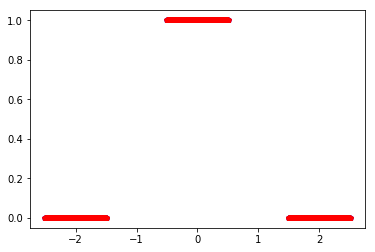

In [327]:
for t in range(10000):
    NN.batch_fit(X,Y,step=0.01, descent_method="Rprop")
    if NN.max_cs < 0.005:
        print(t+1)
        break

NN.prediction(X)
print(NN.validate())
plt.plot(NN.px.T, NN.py.T, "bp", X.T, Y.T, "rp")
plt.show()

In [328]:
ym = NN.ly[0].y.mean(axis=1)

In [329]:
yn = NN.ly[0].y - ym.reshape((NN.ly[0].nn,1))

In [330]:
ba = np.dot(NN.ly[1].w.v, ym.reshape((NN.ly[0].nn,1)))

In [331]:
ev, em = np.linalg.eig(np.dot(yn, yn.T))

In [332]:
operator, pivots=column_operate(em[:,ev/ev.sum() > 0.001])

In [333]:
new_w = np.dot(NN.ly[1].w.v, operator)
print(new_w)

[[-24.20684996+0.j -24.82246025+0.j]]


In [334]:
NN.ly[1].b.assign_values(NN.ly[1].b.v + (np.dot(NN.ly[1].w.v, ym) -np.dot(new_w, ym[pivots])))

In [335]:
NN.ly[1].w.assign_values(new_w)

In [336]:
NN.ly[0].w.assign_values(NN.ly[0].w.v[pivots])
NN.ly[0].b.assign_values(NN.ly[0].b.v[pivots])

In [337]:
NN.ly[0].nn = len(pivots)

In [338]:
NN.prediction(X)
print(NN.validate())
plt.plot(NN.px.T, NN.py.T, "bp", X.T, Y.T, "rp")
plt.show()

TypeError: ufunc 'expit' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

4.22506847786e-05


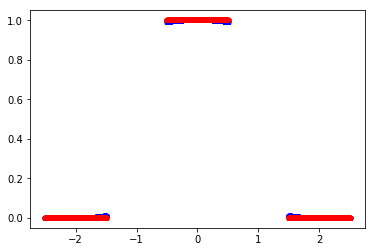

In [297]:
for t in range(10000):
    NN.batch_fit(X,Y,step=0.01, descent_method="Rprop")
    if NN.max_cs < 0.005:
        break

NN.prediction(X)
print(NN.validate())
plt.plot(NN.px.T, NN.py.T, "bp", X.T, Y.T, "rp")
plt.show()

In [298]:
new_w

array([[-10.28623192, -10.81075564]])

In [299]:
NN.ly[1].w.v

array([[-3.00722147, -3.00701175]])